In [2]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [116]:
data = yf.download('TQQQ', start = '1993-01-01', end = '2024-06-01')
data['Day'] = data.index.day_of_week
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Day
Date,,,,,,,
2010-02-11,0.406875,0.434896,0.405573,0.432552,0.418944,3456000,3
2010-02-12,0.420781,0.438073,0.418333,0.434323,0.420660,8601600,4
2010-02-16,0.444531,0.452188,0.437552,0.451146,0.436953,9619200,1
2010-02-17,0.457188,0.458906,0.450313,0.458802,0.444368,19180800,2
2010-02-18,0.458333,0.470260,0.455573,0.467500,0.452793,38860800,3
...,...,...,...,...,...,...,...
2024-05-24,64.250000,65.889999,63.939999,65.349998,65.101021,41160500,4
2024-05-28,65.860001,66.099998,64.800003,66.059998,65.808311,41593200,1
2024-05-29,64.239998,65.440002,64.199997,64.680000,64.433571,39641100,2


In [117]:
'''
Strategy:
Buy: On Tuesday or Wednesday, if the two previous days have consecutively lower closing prices, long at the open
Sell: When the close is higher than the previous day's high, sell at the close
'''
buys = []
buy_dates = []
sells = []
sell_dates = []
index = []
position = False
cash = 1000
data['Daily Cash'] = np.zeros(len(data))
data['Total Value'] = np.zeros(len(data))
data['Daily Cash'][0] = cash
data['Total Value'][0] = cash
shares = 0
for i in range(len(data)):
    if data['Day'][i] == 1 or data['Day'][i] == 2:
        if i > 2 and data['Close'][i-1] < data['Close'][i-2]:
            if data['Close'][i-2] < data['Close'][i-3] and position == False:
                buys.append(data['Open'][i])
                buy_dates.append(data.index[i])
                position = True
                index.append(i)
                shares = cash/data['Open'][i]
                cash = 0
                data['Daily Cash'][i] = cash
    if position == True:
        if i > index[-1] and data['Close'][i] > data['High'][i-1]:
            sells.append(data['Close'][i])
            sell_dates.append(data.index[i])
            position = False
            cash = shares*data['Close'][i]
            data['Daily Cash'][i] = cash
            shares = 0
    data['Total Value'][i] = shares * data['Close'][i] + cash
            



In [118]:
#Calculate the annualized returns of the strategy
returns = (np.array(sells) - np.array(buys)) / np.array(buys)
cumulative_return = np.prod(1 + returns) - 1
total_days = len(data)
annualized_return = (1 + cumulative_return) ** (365 / total_days) - 1
print("Annualized Return: " + str(round(annualized_return * 100, 2)), "%")

Annualized Return: 30.93 %


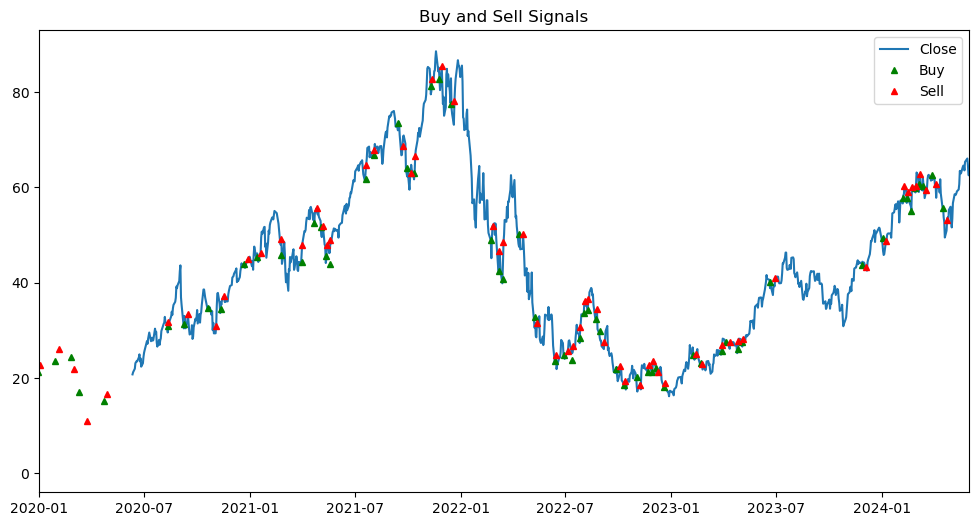

In [119]:
#Plot the buy and sell signals (shrunk to 2020 onward for better visiblity)
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 6))
plt.plot(data['Close'].iloc[-1000:])
plt.plot(buy_dates, buys, '^', color = 'g', markersize = 5)
plt.plot(sell_dates, sells, '^', color = 'r', markersize = 5)
plt.title('Buy and Sell Signals')
plt.legend(['Close', 'Buy', 'Sell'])
plt.xlim(pd.Timestamp('2020-01-01'), data.index[-1])
plt.show()



In [124]:
#Calculate the Sharpe Ratio
data['Daily Return'] = data['Total Value'].pct_change()
data['Daily Return'][0] = 0
mean = data['Daily Return'].mean()
std = data['Daily Return'].std()
sharpe_ratio = mean/std * np.sqrt(252)
sharpe_ratio
 

0.7129953590423094